In [6]:
# import libs

from ortools.linear_solver import pywraplp
from ortools.init import pywrapinit
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

from scipy.spatial import distance_matrix

import numpy as np
import numpy.random as nr
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

import random
import copy
import time
import itertools
import sqlite3


In [25]:
# init parameters

NO_TOWNS = 10 # number of towns (town numbering is from [0, NO_TOWNS-1])
NO_AGENTS = 2
STARTING_TOWN = 0 # set starting town
nr.seed(69) # set fixed seed for rng



In [14]:
# function for creating town coordinates
def create_towns(NO_TOWNS):
    """generate random x and y coordinates for each town"""

    towns_x = nr.randint(0, 100, NO_TOWNS) # x coordinates for NO_TOWNS number of towns
    towns_y = nr.randint(0, 100, NO_TOWNS) # y coordinates for NO_TOWNS number of towns
    
    return towns_x, towns_y


towns_x, towns_y = create_towns(NO_TOWNS) # generate coordinates for each town

start_town_x = towns_x[STARTING_TOWN]
start_town_y = towns_y[STARTING_TOWN]

In [40]:
def create_distance_matrix(towns_x, towns_y):
    """create a matrix of pairwise distances between all towns"""
    towns = list(range(NO_TOWNS))
    df = pd.DataFrame(np.array([towns_x, towns_y]).transpose(), columns=['x', 'y'], index=towns)
    distance_df = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
    return np.round_(distance_df).astype(int)

def create_waiting_time_matrix(method, t=13):
    
    """
    create a matrix of waiting times at each town
    method = ['calculate', 'update']
    """
    
    if method == 'calculate':
        
        def time_fn(time):
            return (t-13)**2 + 60
        
        matrix = np.array([time_fn(time), time_fn(time), time_fn(time), time_fn(time), time_fn(time), 
                           time_fn(time), time_fn(time), time_fn(time), time_fn(time), time_fn(time), ]) # each time function can be different
        
    elif method == 'update':
        def time_update():
            conn = sqlite3.connect('test.db') # connect to real_time waiting time database
            df = pd.DataFrame(conn.execute('SELECT * FROM waiting_times').fetchall(), columns=['town_id', 'waiting_time'])
            return df.to_numpy()[:, 1]
        
        matrix = time_update()  
#     matrix = nr.randint(0, 30, NO_TOWNS)
#     matrix[0] = 0
    
    return matrix

# TIME DEPENDENT TRAVELLING SALESMAN PROBLEM
# How to make graph, waiting time
# waiting_time(town_id, current_time)


dist_matrix = create_distance_matrix(towns_x, towns_y)
waiting_time_matrix = create_waiting_time_matrix('calculate')


In [41]:
waiting_time_matrix

array([60, 60, 60, 60, 60, 60, 60, 60, 60, 60])

In [42]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['dist_matrix'] = dist_matrix
    data['waiting_time_matrix'] = waiting_time_matrix
    data['num_vehicles'] = NO_AGENTS
    data['depot'] = STARTING_TOWN
    
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}\n')
    
    max_route_distance = 0
    max_waiting_time = 0
    routes = []
    route_distances = []
    route_waiting_times = []
    
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        
        route = []
        route_distance = 0
        route_waiting_time = 0
        
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            route.append(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            route_waiting_time += data['waiting_time_matrix'][manager.IndexToNode(index)]
        
        routes.append(route)
        route_distances.append(route_distance)
        route_waiting_times.append(route_waiting_time)
        
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Total Waiting Time along route: {} minutes\n'.format(route_waiting_time)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
        max_waiting_time = max(route_waiting_time, max_waiting_time)
        
    print('Maximum of the route distances: {}m'.format(max_route_distance))
    print('Maximum of the waiting times: {} minutes'.format(max_waiting_time))
    
    return routes, route_distances, route_waiting_times


In [43]:
# Creating callback function for travelling distance cost

def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    
    return data['dist_matrix'][from_node][to_node]

# Creating callback function for waiting time cost
def waiting_time_callback(to_index):
    """Returns the waiting time at a node"""
    # Convert from routing variable index to time matrix NodeIndex
    to_node = manager.IndexToNode(to_index)
    
    return data['waiting_time_matrix'][to_node]

def cost_callback(from_index, to_index):
    """Returns the total cost"""
    return distance_callback(from_index, to_index) + 4*waiting_time_callback(to_index)

In [44]:
"""Entry point of the program."""

walltime = time.time()
cputime = time.process_time()

# Instantiate the data problem.
data = create_data_model()

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['dist_matrix']),
                                       data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# Create and register a transit callback.
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


# Add Distance constraint.
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    5000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    'Distance')


distance_dimension = routing.GetDimensionOrDie('Distance')
distance_dimension.SetGlobalSpanCostCoefficient(100)


# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)

# Setting time limit on solver
search_parameters.time_limit.seconds = 60

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

self_walltime = time.time()-walltime
self_cputime = time.process_time()-cputime

print('Wall time', self_walltime)
print('CPU time', self_cputime)

# Print solution on console.
if solution:
    routes, route_distances, route_waiting_times = print_solution(data, manager, routing, solution)
else:
    print('No solution found !')


Wall time 0.11169099807739258
CPU time 0.109375
Objective: 21519

Route for vehicle 0:
 0 ->  9 ->  4 ->  1 ->  3 ->  2 -> 0
Distance of the route: 208m
Total Waiting Time along route: 360 minutes

Route for vehicle 1:
 0 ->  7 ->  5 ->  8 ->  6 -> 0
Distance of the route: 211m
Total Waiting Time along route: 300 minutes

Maximum of the route distances: 211m
Maximum of the waiting times: 360 minutes


In [45]:
def plot_routes(routes, waitingtime=False):
    """plot the routes for each vehicle"""
    
    plt.figure(figsize=(6, 6))
    
    # loop through vehicles
    
    for route in routes:
        closed_route = route.append(STARTING_TOWN)
        plt.plot(towns_x[route], towns_y[route], 'o-')
        plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X
        plt.title(f'OR-Tools VRP Solver\n{NO_TOWNS} Waypoints, {NO_AGENTS} Robots\nTime taken: {self_walltime:.3}s')
        
    if waitingtime == True:
        for town in range(NO_TOWNS):
        
#         plt.text(towns_x[town]-1, towns_y[town]-3, s=town, c='red')
            plt.text(towns_x[town]+2, towns_y[town]+2, s=waiting_time_matrix[town])
        
#     for town in range(NO_TOWNS):
#         plt.text(towns_x[town]+1, towns_y[town]+1, s=waiting_time_matrix[town])

#     for town in range(NO_TOWNS):        
#         plt.text(towns_x[town]-1, towns_y[town]-3, s=town, c='red')

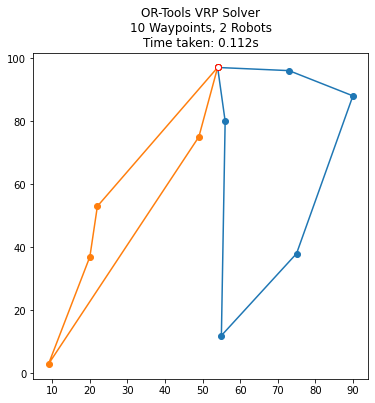

In [46]:
plot_routes(routes)

# With 'Waiting Time' cost

In [47]:
"""Entry point of the program."""

walltime = time.time()
cputime = time.process_time()

# Instantiate the data problem.
data = create_data_model()

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['dist_matrix']),
                                       data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# Create and register a transit callback.
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Create and register a waiting time callback.
wait_callback_index = routing.RegisterUnaryTransitCallback(waiting_time_callback)

# Add Distance constraint.
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    1000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    'Distance')

# Add Waiting Time constraint
routing.AddDimension(
    wait_callback_index,
    0,
    200,
    True,
    'Waiting Time')

distance_dimension = routing.GetDimensionOrDie('Distance')
distance_dimension.SetGlobalSpanCostCoefficient(100)

time_dimension = routing.GetDimensionOrDie('Waiting Time')
time_dimension.SetGlobalSpanCostCoefficient(100)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

# Setting time limit on solver
search_parameters.time_limit.seconds = 30

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

self_walltime = time.time()-walltime
self_cputime = time.process_time()-cputime

print('Wall time', self_walltime)
print('CPU time', self_cputime)

# Print solution on console.
if solution:
    routes, route_distances, route_waiting_times = print_solution(data, manager, routing, solution)
else:
    print('No solution found !')


Wall time 1.798811435699463
CPU time 1.78125
No solution found !


In [48]:
def plot_routes(routes):
    """plot the routes for each vehicle"""
    
    plt.figure(figsize=(6, 6))
    
    # loop through vehicles
    
    for route in routes:
        closed_route = route.append(STARTING_TOWN)
        plt.plot(towns_x[route], towns_y[route], 'o-')
        plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X
        plt.title(f'OR-Tools VRP Solver\n{NO_TOWNS} Waypoints, {NO_AGENTS} Robots\nTime taken: {self_walltime:.3}s')
        
    for town in range(NO_TOWNS):
        
#         plt.text(towns_x[town]-1, towns_y[town]-3, s=town, c='red')
        plt.text(towns_x[town]+2, towns_y[town]+2, s=waiting_time_matrix[town])
        

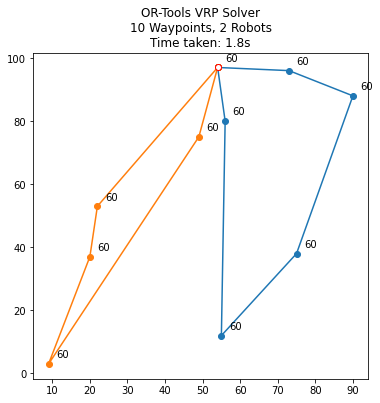

In [49]:
plot_routes(routes)

In [ ]:
# Add dynamic time function

